In [1]:
from os.path import join
from io import StringIO
from collections import defaultdict, OrderedDict

import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

import qnet
from qnet.algebra import *

import QDYN

from src.notebook_plots_v1 import show_summary_dicke
from src.single_sided_network_v1 import network_slh
from src.dicke_half_model_v2 import write_dicke_half_model, err_dicke_half
from src.clusterjob_actions_v1 import (
    submit_crab, submit_propagation, wait_for_clusterjob)

from doit.tools import register_doit_as_IPython_magic
import clusterjob

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
qnet.init_printing()

In [4]:
register_doit_as_IPython_magic()

In [5]:
%run -i module.py

In [6]:
module('load', 'intel/xe2011')
module('load', 'mpi')

In [7]:
clusterjob.JobScript.read_defaults('./config/mlhpc_cluster.ini')
clusterjob.JobScript.cache_folder = './data/doit_clusterjobs/cache_crab'

In [8]:
clusterjob.JobScript.clear_cache_folder()

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Does CRAB yield better results? (4 nodes)

## task definitions

In [9]:
def runfolder(row):
    return './data/CRAB/4nodes_kappa1e0_T%d_E0cycles%d_ncrab%d_seed%d' % (
        row['T'], row['E0_cycles'], row['n_crab'], row['seed'])

In [10]:
def runfolders(params_df):
    """Return a list of all the runfolders"""
    rfs = OrderedDict([])
    for ind, row in params_df.iterrows():
        rfs[runfolder(row)] = 1
    return list(rfs.keys())

In [11]:
def task_create_runfolder():
    """Create all necessary runfolders for the runs defined in params_df"""
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(rf),
            'actions': [
                (write_dicke_half_model, [slh,],  dict(
                    rf=rf, T=row['T'], theta=0, nt=500,
                    kappa=1.0, E0_cycles=row['E0_cycles'], mcwf=True,
                    non_herm=True, complex_pulses=True))],
            'targets': [join(rf, 'config')],
            'uptodate': [True, ] # up to date if target exists
        }

In [12]:
def task_submit_crab():
    """Run optimization for every runfolder from params_df"""
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(rf),
            'actions': [
                (submit_crab, [rf, ], dict(
                    n_crab=int(row['n_crab']), n_trajs=int(row['n_trajs']),
                    seed=int(row['seed']), complex=True))],
            'file_dep': [join(rf, 'config')],
            'targets': [join(rf, 'pulse1.oct.dat')],
            'uptodate': [True, ] # up to date if target exists
        }

In [13]:
def task_wait_for_crab():
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(rf),
            'task_dep': ['submit_crab:%s' % rf],
            'actions': [
                (wait_for_clusterjob, [join(rf, 'crab.job.dump')], {}),]}

In [14]:
def task_submit_propagation():
    """Run optimization for every runfolder from params_df"""
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(rf),
            'actions': [
                (submit_propagation, [rf, ], dict(n_trajs=row['n_trajs']))],
            'file_dep': [join(rf, 'pulse1.oct.dat'),],}

In [15]:
def task_wait_for_propagation():
    """Run optimization for every runfolder from params_df"""
    for ind, row in params_df.iterrows():
        rf = runfolder(row)
        yield {
            'name': str(rf),
            'task_dep': ['submit_propagation:%s' % rf],
            'actions': [
                (wait_for_clusterjob, [join(rf, 'prop.job.dump')], {}),]}

## Optimization

In [16]:
params_data_str = r'''
#    T  E0_cycles  n_crab n_trajs  seed
    50          2       5       5     0
    50          2       5       5     1
    50          2       2       5     0
    50          2       2       5     1
    50          2       2      60     2
    50          4       5       5     0
    50          4       5       5     1
    50          4       2       5     0
    50          4       2       5     1
   100          2       5       5     0
   100          2       5       5     1
   100          2       2       5     0
   100          2       2       5     1
'''
params_df = pd.read_fwf(
        StringIO(params_data_str), comment='#', header=1,
        names=['T', 'E0_cycles', 'n_crab', 'n_trajs', 'seed'])

In [17]:
params_df

,T,E0_cycles,n_crab,n_trajs,seed
0,50,2,5,5,0
1,50,2,5,5,1
2,50,2,2,5,0
3,50,2,2,5,1
4,50,2,2,60,2
5,50,4,5,5,0
6,50,4,5,5,1
7,50,4,2,5,0
8,50,4,2,5,1
9,100,2,5,5,0


In [18]:
slh = network_slh(n_cavity=2, n_nodes=4, topology='driven_bs_fb')

In [19]:
# %doit reset-dep

In [20]:
%doit wait_for_crab

-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles2_ncrab5_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles2_ncrab5_seed1
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles2_ncrab2_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles2_ncrab2_seed1
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles2_ncrab2_seed2
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles4_ncrab5_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles4_ncrab5_seed1
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles4_ncrab2_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T50_E0cycles4_ncrab2_seed1
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T100_E0cycles2_ncrab5_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T100_E0cycles2_ncrab5_seed1
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T100_E0cycles2_ncrab2_seed0
-- create_runfolder:./data/CRAB/4nodes_kappa1e0_T100_E0cycles2_ncrab2_seed1
-- submit_crab:./data

KeyboardInterrupt: 

In [ ]:
#%doit propagate


## STATUS

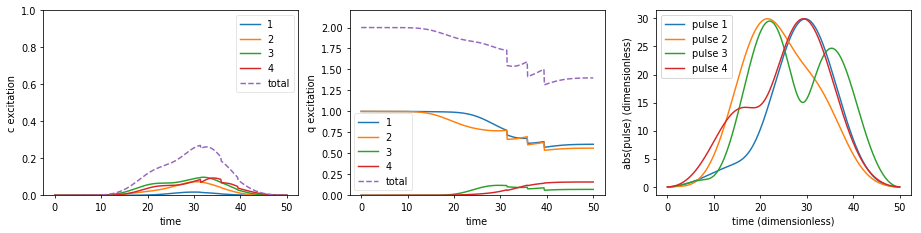

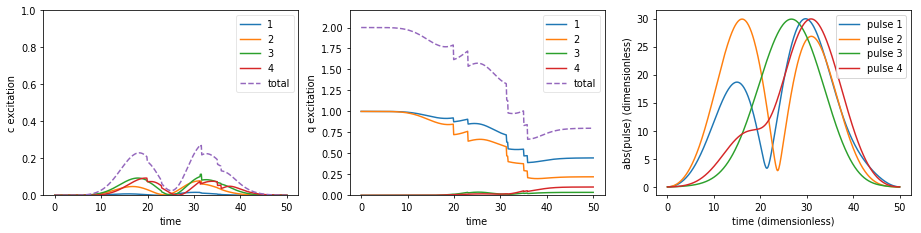

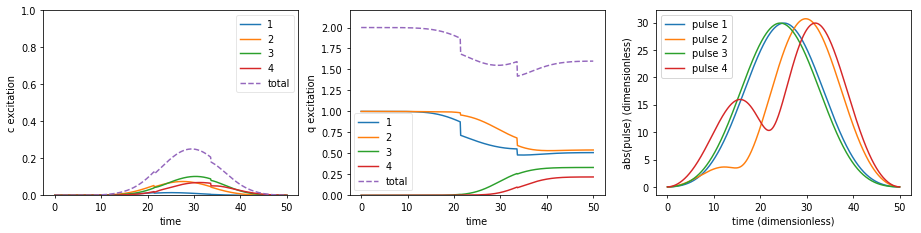

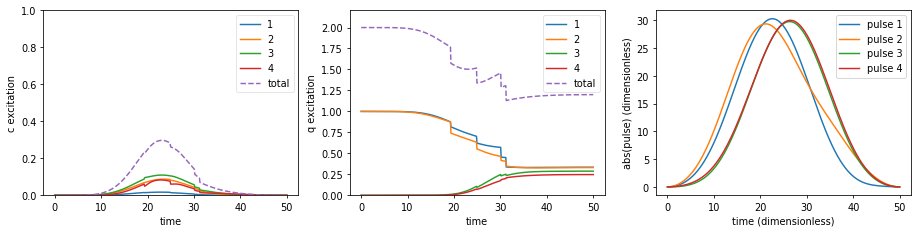

/home/goerz/.conda/envs/default/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


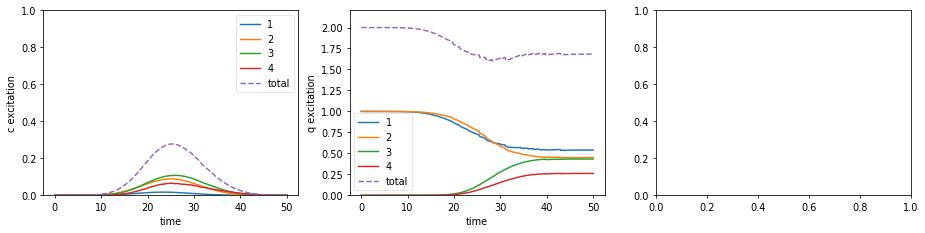

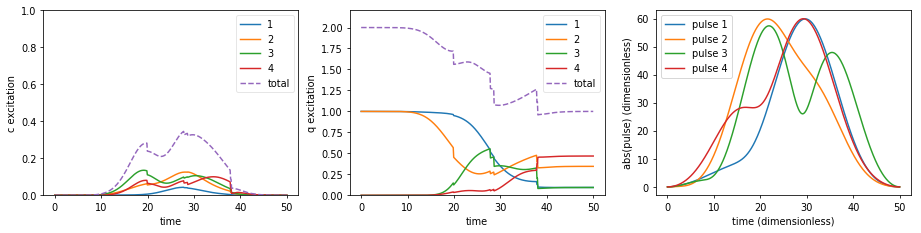

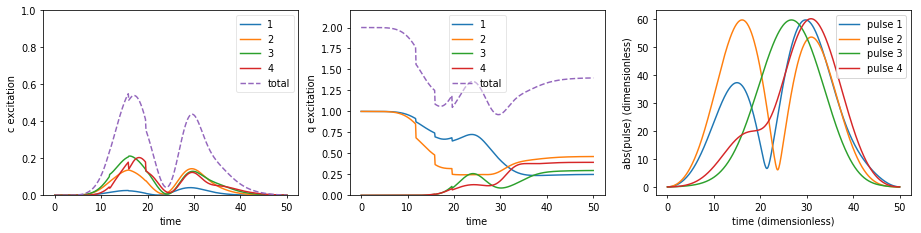

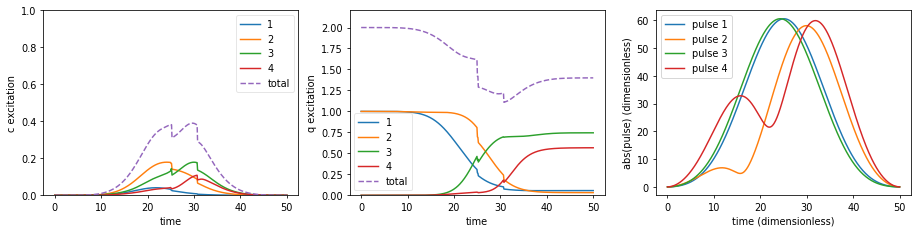

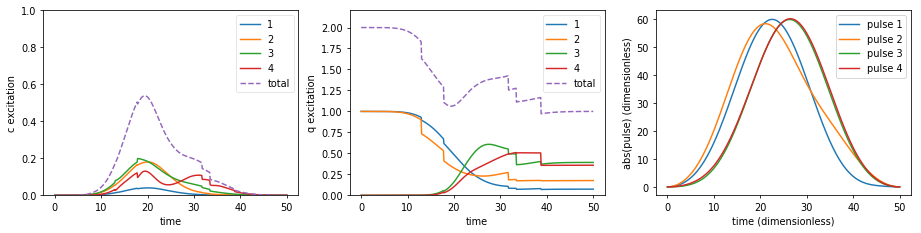

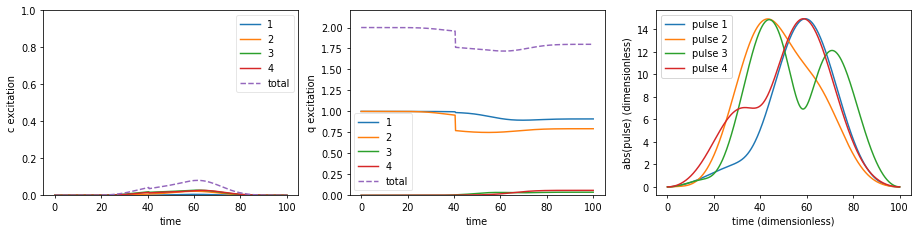

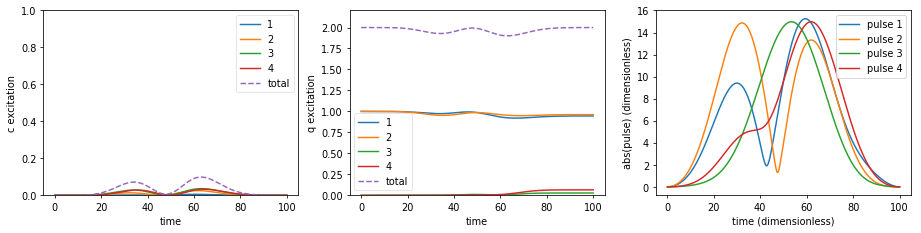

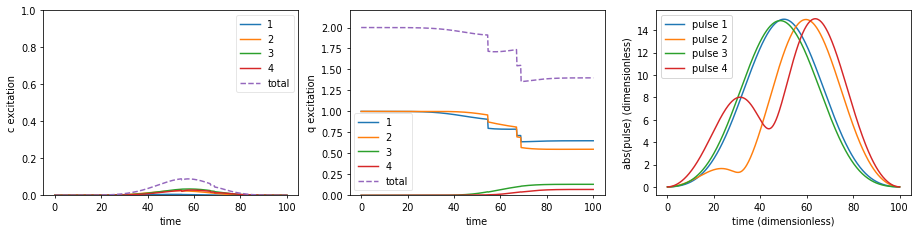

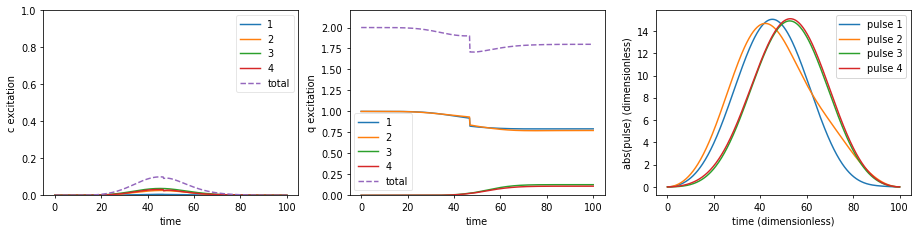

In [21]:
for rf in runfolders(params_df):
    show_summary_dicke(rf, pulses='pulse*.oct.dat')

In [ ]:
x = 1